In [2]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [3]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [4]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [5]:
%matplotlib inline

In [6]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(20987, 28)
(20987, 3)


In [7]:
X_motion_CoM_continuous[0]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00, -4.96986205e-03,
       -4.08022931e-03, -1.09604628e-03,  1.22067254e-03, -7.11765578e-04,
       -6.25571855e-03,  2.29490617e-01,  1.71660343e-01, -4.07593556e-01,
        2.33458057e-01, -1.69934576e-01, -4.07590576e-01, -2.44067879e-01,
        1.71401114e-01, -4.07586282e-01, -2.47972604e-01, -1.69831881e-01,
       -4.07582734e-01,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

In [8]:
Y_motion_CoM_continuous[0]

array([ 8.73479464e-03, -5.64902313e-03,  2.51590148e-05])

# Multivariate Linear Regression (CoM Prediction)

In [9]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 22] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(10339, 28)
(10339, 3)


## Predict CoM (x) movement

In [11]:
X_motion_CoM_FR_RL[0, :]

array([0.10000000149, 0.0, 0.0, -0.000890185791332, -0.00484342625699,
       -0.0016179894701, -0.00407560999425, -0.00107515501585,
       -0.00510968513852, 0.23051781299999163, 0.1655742714433,
       -0.40774758989619997, 0.2341179489999945, -0.1641604241797,
       -0.4077428318662, -0.2458713250000102, 0.1643310085713,
       -0.4077813050943, -0.24857248099999651, -0.1633396735827,
       -0.40777665639239996, False, True, True, False, 0.10000000149, 0.0,
       0.0], dtype=object)

In [12]:
Y_motion_CoM_FR_RL[0, :]

array([0.008710594356770684, -0.005823853354034292,
       0.00010580817889640592], dtype=object)

### Linear Regression

In [13]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9742869887380425
RMSE:  0.006754509135204195
The lowest error is:  1.7536971566572274e-06
The highest error is:  0.08408619366125114
The avg. error is:  0.0035250633884931193


In [14]:
model_fr_com_x.coef_

array([[ 9.59733942e-03,  1.84429939e-02,  1.58683948e-02,
         1.21596511e-01, -3.22463364e-02,  1.55011567e-04,
         1.96935440e-02, -4.24067395e-02,  3.53699519e-02,
         1.46701020e-03,  1.02717710e-01, -3.98563621e-02,
         9.24792547e-02,  1.90660254e-02,  2.05498477e-01,
        -1.26494972e-01,  2.09232937e-01, -1.30029779e-01,
         7.17009213e-02,  1.56106851e-02]])

In [15]:
model_fr_com_x.intercept_

array([-0.00468173])

In [34]:
input_ = np.array([[0,
           0,
           0,
         0.2,
           0,
           0,
  -0.0182683,
  -0.0111934,
 -0.00122973,
-6.13354e-05,
 -0.00529435,
-0.000334423,
    0.236372,
     0.17294,
    0.238277,
   -0.173703,
   -0.239661,
    0.155102,
   -0.240868,
   -0.1557071,]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[0.0252593]]


Text(0, 0.5, 'Predictions')

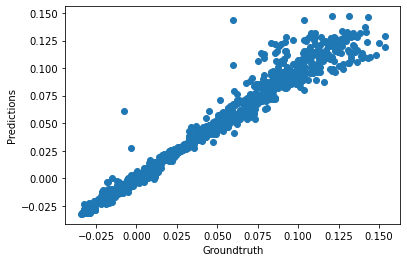

In [17]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [18]:
#%store model_fr_com_x

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [20]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [21]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9643989824063354
RMSE:  0.007671866541668758
The lowest error is:  2.2991861229129662e-07
The highest error is:  0.09104776812022475
The avg. error is:  0.004049571014125829


In [22]:
model_fr_com_y.coef_

array([[ 2.34042170e-02,  5.48680900e-03, -1.66045839e-02,
        -2.74308950e-02,  1.51090057e-01,  2.42060292e-04,
        -6.06831151e-03,  4.80238777e-02,  1.12309088e-01,
         9.23914769e-03,  8.21521957e-03,  4.18897975e-02,
         8.54691304e-03, -7.58887254e-03,  7.55532076e-02,
         2.58800108e-01,  8.00942563e-02,  2.22827815e-01,
        -2.30548156e-02, -1.00312683e-02]])

In [23]:
model_fr_com_y.intercept_

array([-0.00333011])

Text(0, 0.5, 'Predictions')

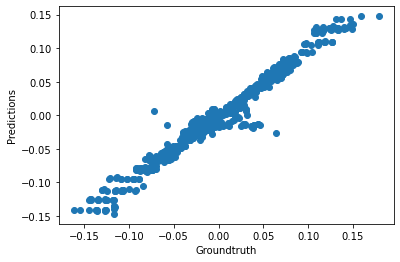

In [24]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [25]:
#%store model_fr_com_y

In [26]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [27]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")

## Predict CoM -> Yaw

In [28]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # Current motion command
               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9839096009699861
RMSE:  0.004294834633740838
The lowest error is:  2.176664286701168e-07
The highest error is:  0.12939558442095295
The avg. error is:  0.0018329240609863589


In [29]:
model_fl_com_theta.coef_

array([[-0.00661641,  0.00117121,  0.08456548,  0.00155278, -0.00260304,
         0.02916036, -0.0070565 ,  0.01170454, -0.04534085, -0.01038279,
        -0.08539721,  0.05447219,  0.01954089, -0.04428893,  0.00016834,
         0.00976488, -0.03258159, -0.0114951 ,  0.01034275, -0.00616154]])

In [30]:
model_fl_com_theta.intercept_

array([0.0008823])

Text(0, 0.5, 'Predictions')

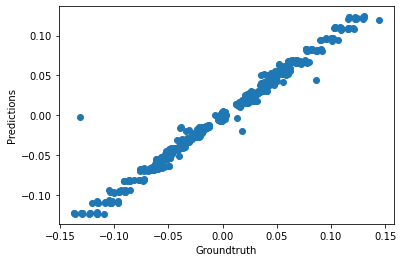

In [31]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")